# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from parse_utils import (find_categories,
                         replace_missing_data,
                         find_columns_with_missing_data,
                         split_dataset,
                         find_row_with_missing_data,
                         search_music_styles,
                         encoded_rows_with_dummies,
                         create_feature_rows,
                         first_pc_analysis,
                         check_null_types,
                         format_rows_missing_data,
                         find_rows_with_null_data_in_summary,
                         find_mixed_data_type_rows,
                         sort_pca_by_weights
                         )
from plot_utils import scree_plot

from parse_utils import decade as DECADE

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
semi = ';'

# Load in the general demographics data.
azdias_demogrh_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=semi)

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=semi)

# Load the Demographics for customer mail-order
cst_demogrh_df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=semi)

In [3]:
# operate on the copy datat set
general_demo_df = azdias_demogrh_df.copy()
summary_df = feat_info.copy()
customer_demo_df = cst_demogrh_df.copy()

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
rows, cols = azdias_demogrh_df.shape
print('General Demographics Dataset: Number of Rows {}, Number of Column: {}'.format(rows, cols))

General Demographics Dataset: Number of Rows 891221, Number of Column: 85


In [5]:
rows, cols = feat_info.shape
print('Feature Summary Dataset: Number of Rows {}, Number of Column: {}'.format(rows, cols))

Feature Summary Dataset: Number of Rows 85, Number of Column: 4


In [10]:
rows, cols = cst_demogrh_df.shape
print('Customer Demographics Dataset: Number of Rows {}, Number of Column: {}'.format(rows, cols))

Customer Demographics Dataset: Number of Rows 191652, Number of Column: 85


In [11]:
azdias_demogrh_df.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
#check for null values
azdias_demogrh_df.isna().sum().sort_values(ascending=True)

,0
AGER_TYP,0
SEMIO_SOZ,0
SEMIO_FAM,0
SEMIO_REL,0
SEMIO_MAT,0
SEMIO_VERT,0
SEMIO_LUST,0
SEMIO_ERL,0
PRAEGENDE_JUGENDJAHRE,0
SEMIO_KULT,0


In [13]:
azdias_demogrh_df.dtypes

,0
AGER_TYP,int64
ALTERSKATEGORIE_GROB,int64
ANREDE_KZ,int64
CJT_GESAMTTYP,float64
FINANZ_MINIMALIST,int64
FINANZ_SPARER,int64
FINANZ_VORSORGER,int64
FINANZ_ANLEGER,int64
FINANZ_UNAUFFAELLIGER,int64
FINANZ_HAUSBAUER,int64


In [14]:
azdias_demogrh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [15]:
azdias_demogrh_df.isna().sum()

,0
AGER_TYP,0
ALTERSKATEGORIE_GROB,0
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0
FINANZ_SPARER,0
FINANZ_VORSORGER,0
FINANZ_ANLEGER,0
FINANZ_UNAUFFAELLIGER,0
FINANZ_HAUSBAUER,0


In [16]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [17]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  75 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [18]:
feat_info.dtypes

,0
attribute,object
information_level,object
type,object
missing_or_unknown,object


In [19]:
cst_demogrh_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [20]:
cst_demogrh_df.dtypes

,0
AGER_TYP,int64
ALTERSKATEGORIE_GROB,int64
ANREDE_KZ,int64
CJT_GESAMTTYP,float64
FINANZ_MINIMALIST,int64
FINANZ_SPARER,int64
FINANZ_VORSORGER,int64
FINANZ_ANLEGER,int64
FINANZ_UNAUFFAELLIGER,int64
FINANZ_HAUSBAUER,int64


In [21]:
cst_demogrh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               191652 non-null  int64  
 1   ALTERSKATEGORIE_GROB   191652 non-null  int64  
 2   ANREDE_KZ              191652 non-null  int64  
 3   CJT_GESAMTTYP          188439 non-null  float64
 4   FINANZ_MINIMALIST      191652 non-null  int64  
 5   FINANZ_SPARER          191652 non-null  int64  
 6   FINANZ_VORSORGER       191652 non-null  int64  
 7   FINANZ_ANLEGER         191652 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 9   FINANZ_HAUSBAUER       191652 non-null  int64  
 10  FINANZTYP              191652 non-null  int64  
 11  GEBURTSJAHR            191652 non-null  int64  
 12  GFK_URLAUBERTYP        188439 non-null  float64
 13  GREEN_AVANTGARDE       191652 non-null  int64  
 14  HEALTH_TYP             191652 non-nu

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [25]:

azdias_demogrh_copy_df = replace_missing_data(feat_info, azdias_demogrh_df)

In [12]:
azdias_demogrh_copy_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [26]:
column_count_of_missing_df = find_columns_with_missing_data(azdias_demogrh_copy_df)

In [27]:
column_count_of_missing_df

,column_name,null_count,percentage
TITEL_KZ,TITEL_KZ,889061,99.757636
AGER_TYP,AGER_TYP,685843,76.955435
KK_KUNDENTYP,KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,GEBURTSJAHR,392318,44.020282
ALTER_HH,ALTER_HH,310267,34.813699
KKK,KKK,158064,17.735668
REGIOTYP,REGIOTYP,158064,17.735668
W_KEIT_KIND_HH,W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG1,KBA05_ANTG1,133324,14.959701


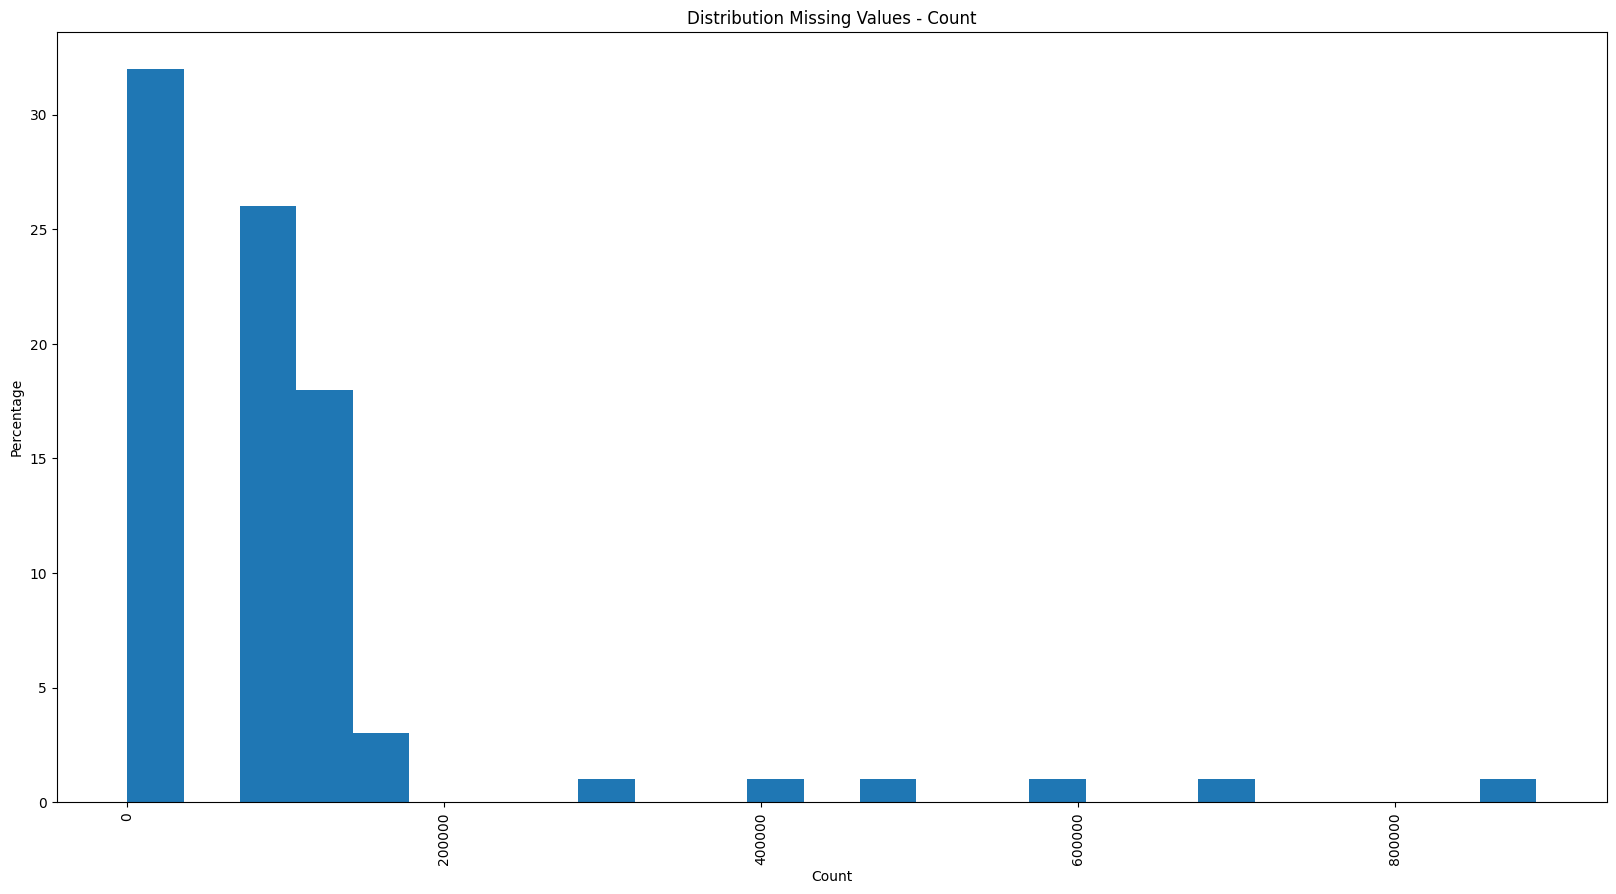

In [28]:
#Lets see histplot
figure = plt.figure(figsize=(20,10))
plt.hist(column_count_of_missing_df['null_count'], bins=25, density=False)
plt.title('Distribution Missing Values - Count')
plt.ylabel('Percentage')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.show()

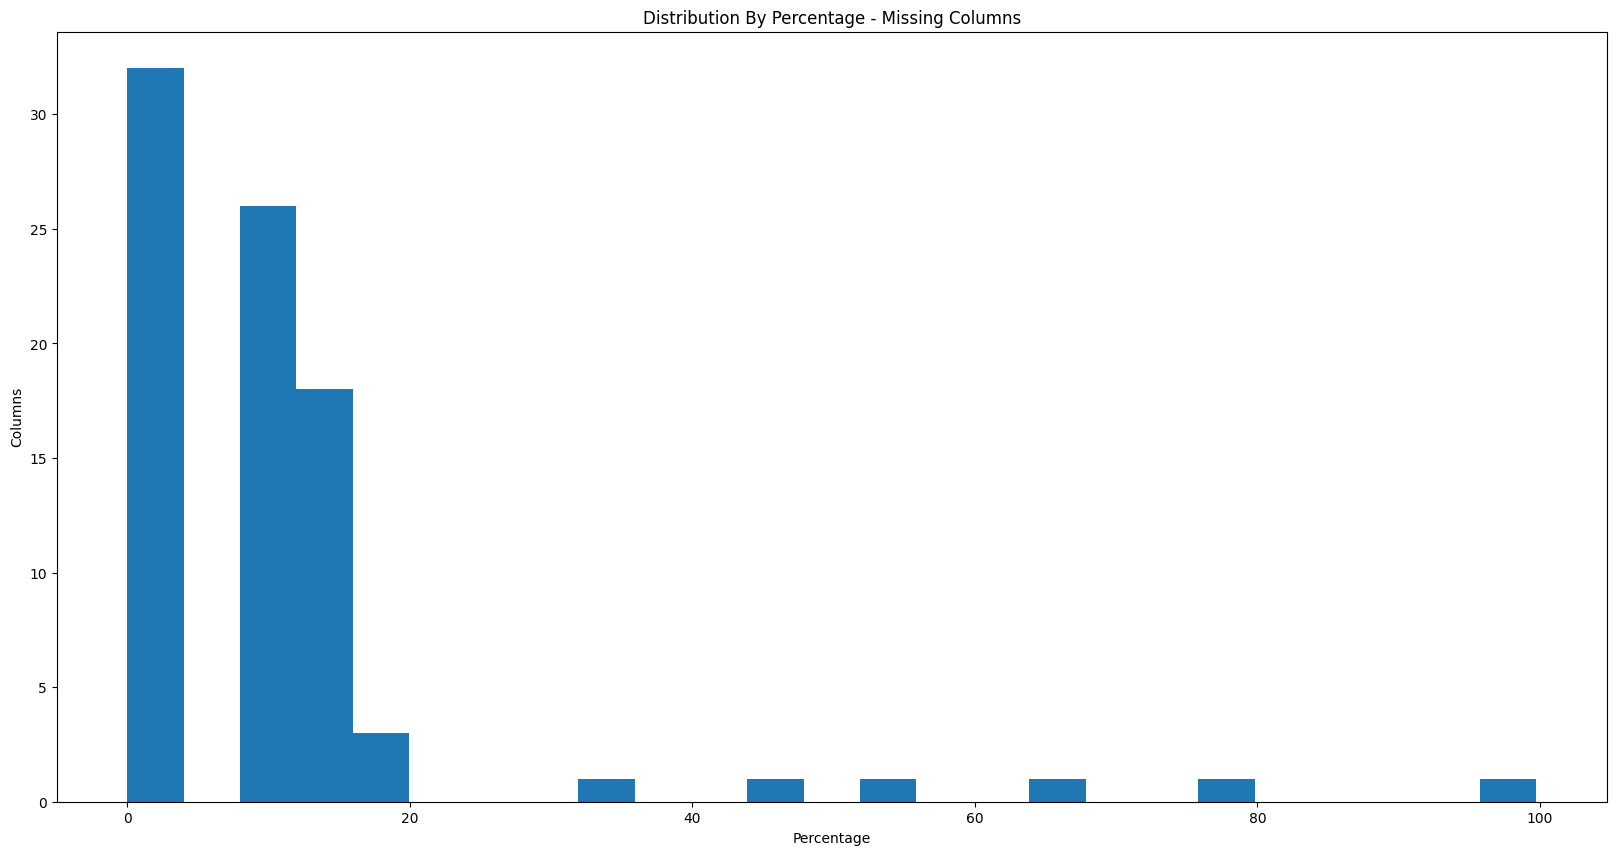

In [29]:
figure = plt.figure(figsize=(20,10))
plt.hist(column_count_of_missing_df['percentage'], bins=25, density=False)
plt.title('Distribution By Percentage - Missing Columns')
plt.ylabel('Columns')
plt.xlabel('Percentage')
plt.show()


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

OBSERVATION:

The hist Plot shows that there are alot of outliners have a very high percernt. There are outliners that above 20 percent which have a very high count and percentage. If the data is not removed from the data frame. it will skewed the information.  Dropping the columns that are above 20 percent will help with the data not being skewed to the right.



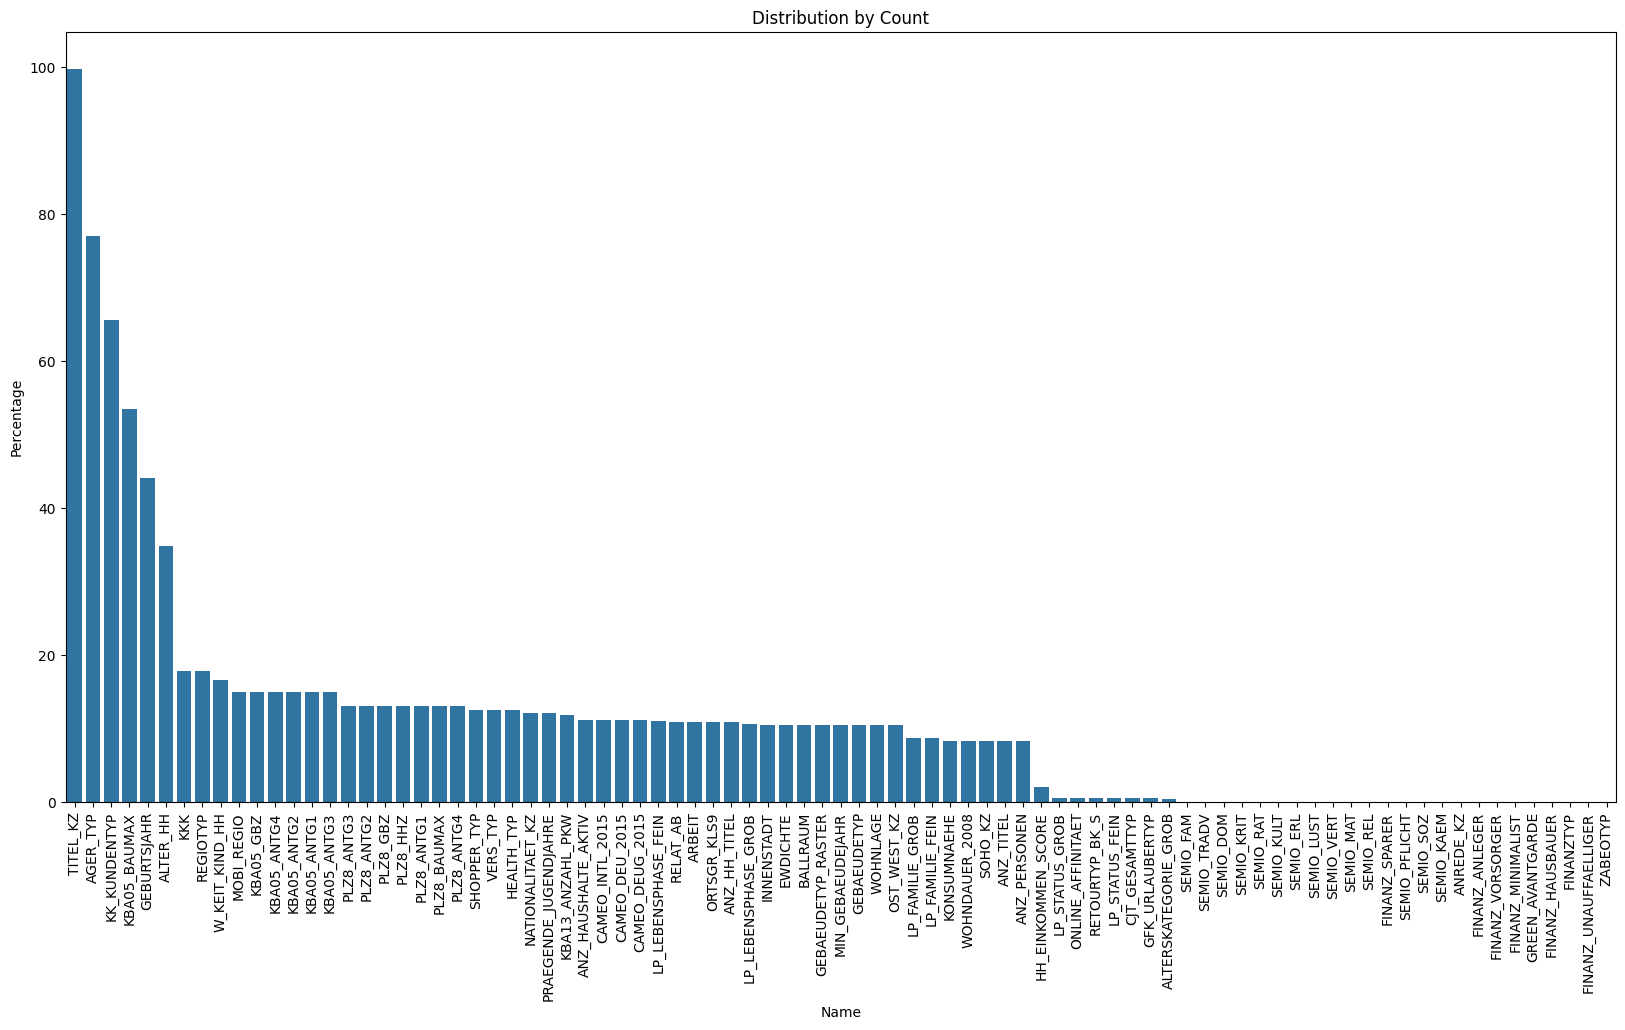

''

In [17]:
import matplotlib.ticker as mtick
plt.figure(figsize=(20,10))
sns.barplot(column_count_of_missing_df.sort_values(by='percentage', ascending=False), x='column_name', y='percentage')
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.ylim(0,1)
# plt.ylim(0,100)
plt.title('Distribution by Count')
plt.ylabel('Percentage')
plt.xlabel('Name')
plt.xticks(rotation=90)
plt.show()
;

Observeration:

The outliners in the data has been clearly identified from the highest percentage to the lowest percent. Outliners that are more than 20% will be drop from the dataframe.
The Query below will provide us the information where the percentage is higher the 20% that are displayed by the graph.

In [30]:
columns_with_over_20_percent_df = column_count_of_missing_df[column_count_of_missing_df['percentage']>20]
print('Followoing Column Have High Percertage of Missing Data')
columns_with_over_20_percent_df

Followoing Column Have High Percertage of Missing Data


,column_name,null_count,percentage
TITEL_KZ,TITEL_KZ,889061,99.757636
AGER_TYP,AGER_TYP,685843,76.955435
KK_KUNDENTYP,KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,GEBURTSJAHR,392318,44.020282
ALTER_HH,ALTER_HH,310267,34.813699


***Observation***

The attributes above tells me that there are 6 columns that have missing data that is over the 20 percentage.  It indicates alot of missing data it is right skewed in the barplot.

In [31]:
columns_to_drop_list = columns_with_over_20_percent_df['column_name'].tolist()
columns_to_drop_list

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

Drop the columna from Summary Dataframe
Reset the index on DataFrame
Do a before and after count

In [32]:
#Before Dropping Column Count
azdias_demogrh_copy_df.shape


(891221, 85)

Shape after Drop and reset index

In [33]:
# Drop columns that are over 20 percent missing from summary dataframe
azdias_demogrh_copy_df.drop(columns=columns_to_drop_list, inplace=True, axis=1)

In [34]:
#reset the index
azdias_demogrh_copy_df.reset_index(drop=True, inplace=True)

In [35]:
#Verify count of columns remove
azdias_demogrh_copy_df.shape

(891221, 79)

In [36]:
#check thedata
azdias_demogrh_copy_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)
OBSERVATION:

The patterns in the missing data is decrease than flatten out especially with data that contains a high percentage.Observation from the grpah shows there is consistent amout of data missing and which means the data still needs cleaning. The histgram and Barplot provides a visual representation.

There where a total of 6 Columns that was Removed from  Summary Data Set

AGER_TYP             
GEBURTSJAHR       
TITEL_KZ             
ALTER_HH             
KK_KUNDENTYP     
KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [50]:
#find row with missing data call function
row_missing_azdias_summary_df=find_row_with_missing_data(azdias_demogrh_copy_df)

row_missing_azdias_summary_df=azdias_demogrh_copy_df.isna().sum(axis=1)
print(len(row_missing_azdias_summary_df))

In [51]:
#Lets look at the Statistics
row_missing_azdias_summary_df.info()

<class 'pandas.core.series.Series'>
RangeIndex: 891221 entries, 0 to 891220
Series name: None
Non-Null Count   Dtype
--------------   -----
891221 non-null  int64
dtypes: int64(1)
memory usage: 6.8 MB


In [53]:
row_missing_azdias_summary_df.shape

(891221,)

In [54]:
azdias_demogrh_copy_df.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


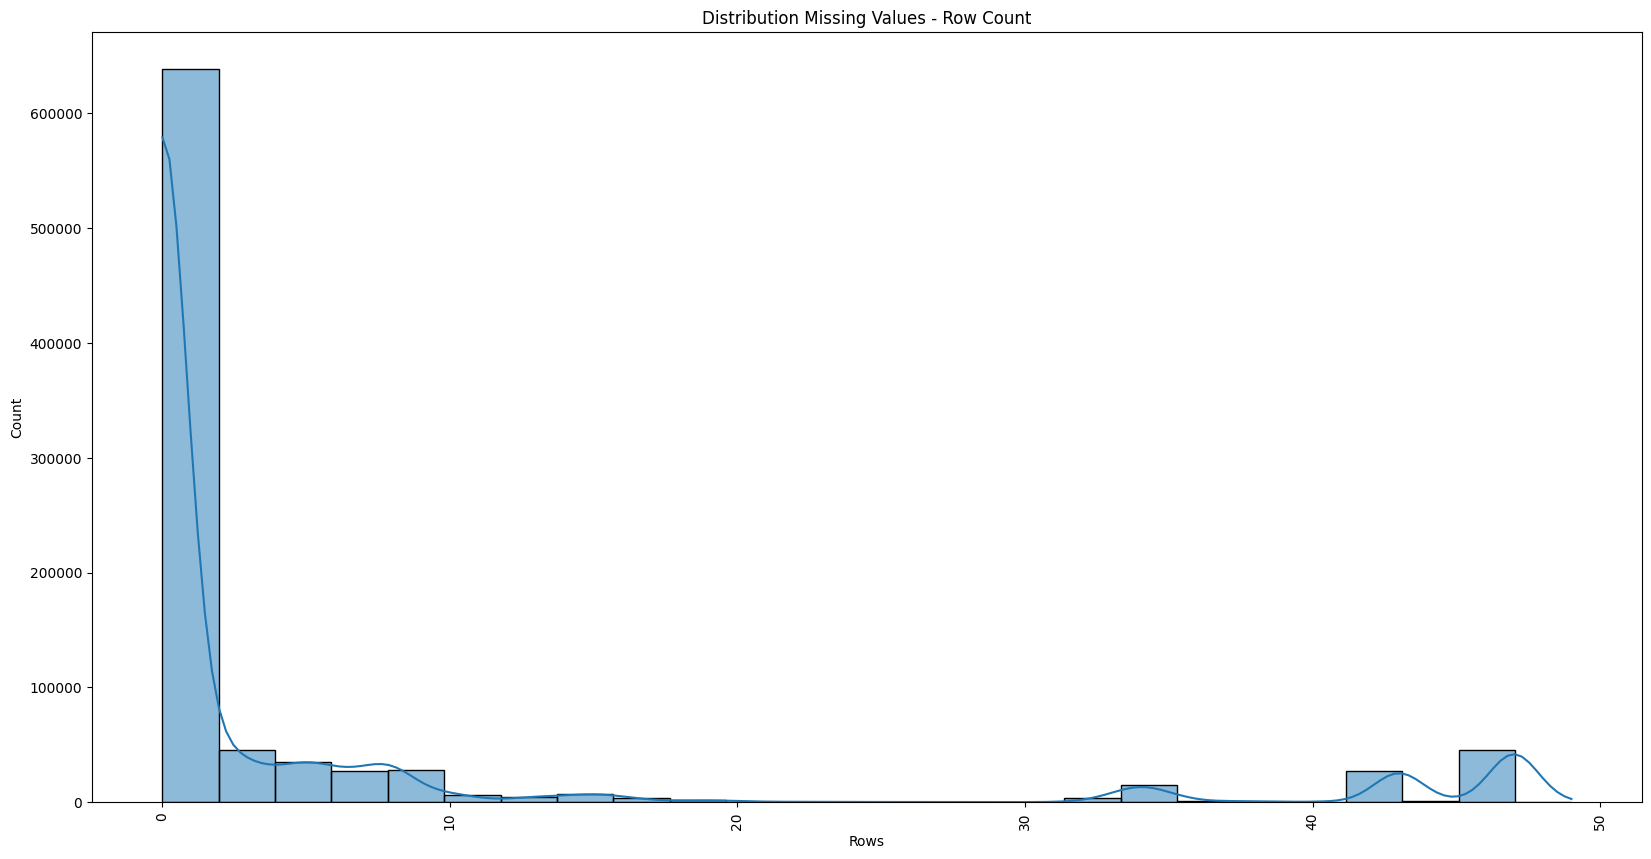

In [55]:
#plt history of row missing data
plt.figure(figsize=(20,10))
sns.histplot(row_missing_azdias_summary_df, bins=25, kde=True)
plt.title('Distribution Missing Values - Row Count')
plt.ylabel('Count')
plt.xlabel('Rows')
plt.xticks(rotation=90)
plt.show()

In [56]:
#split the dataset
rows_upper_threshold, rows_lower_threshold = split_dataset(azdias_demogrh_copy_df,row_missing_azdias_summary_df, 20)

In [57]:
#Subset greater than 20
rows_upper_threshold.shape

(93795, 79)

In [58]:
#Subset less than 30
rows_lower_threshold.shape

(797426, 79)

In [59]:
#rows less than 20 looking at first few rows
rows_lower_threshold.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0


In [65]:
# lets find the rows that are null values in azdias summary data frame
# find_rows_with_null_data_in_summary will return a list of missing data

column_missing_data =  find_rows_with_null_data_in_summary(azdias_demogrh_copy_df)
column_missing_data

['ANREDE_KZ',
 'SEMIO_TRADV',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'ZABEOTYP']

In [66]:
def display_plots(column_name):

    """
    Disply Plot Using MatPlotLib

    Counting Values: The value_counts() method is used to count occurrences in both subsets.
    For the second subset, we normalize the counts to get percentages.


    """
    fig, axes = plt.subplots(figsize=(12,4), ncols=2)

    #Count occurances for both subsets
    upper_threshold_count = rows_upper_threshold[column_name].value_counts()
    lower_threshold_count = rows_lower_threshold[column_name].value_counts(normalize=True) * 100


    axes[0].bar(upper_threshold_count.index, upper_threshold_count.values, color='blue')
    axes[0].set_title('High Count Missing Information')
    axes[0].set_xlabel('Categories')
    axes[0].set_ylabel('Count')


    axes[1].bar(lower_threshold_count.index, lower_threshold_count.values, color='orange')
    axes[1].set_title('Low Count Missing Information')
    axes[1].set_xlabel('Categories')
    axes[1].set_ylabel('Percentage')
    plt.tight_layout()
    plt.show()

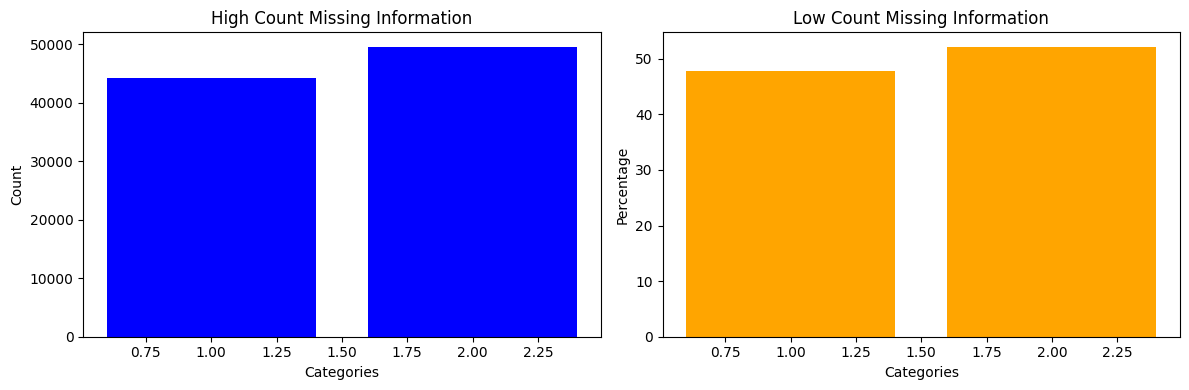

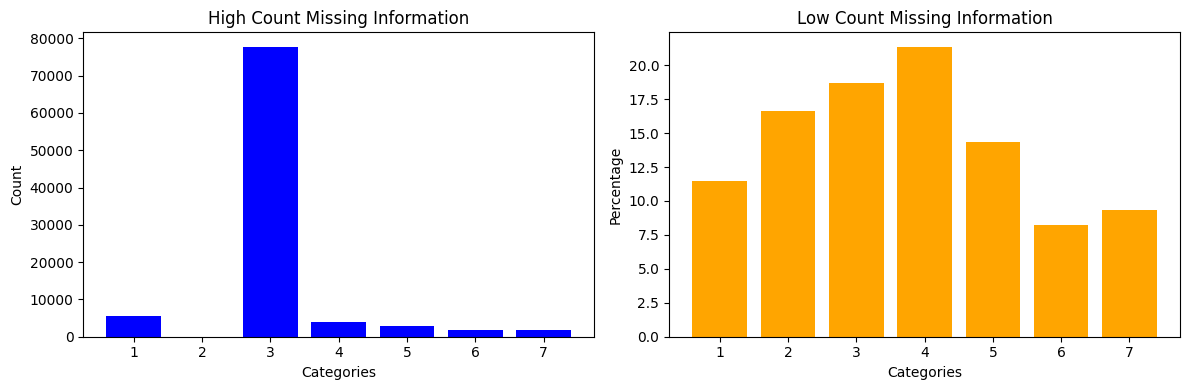

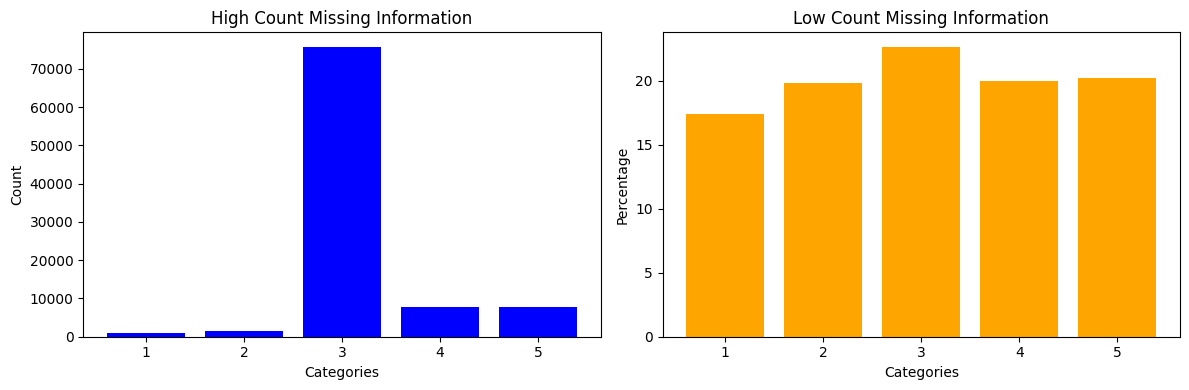

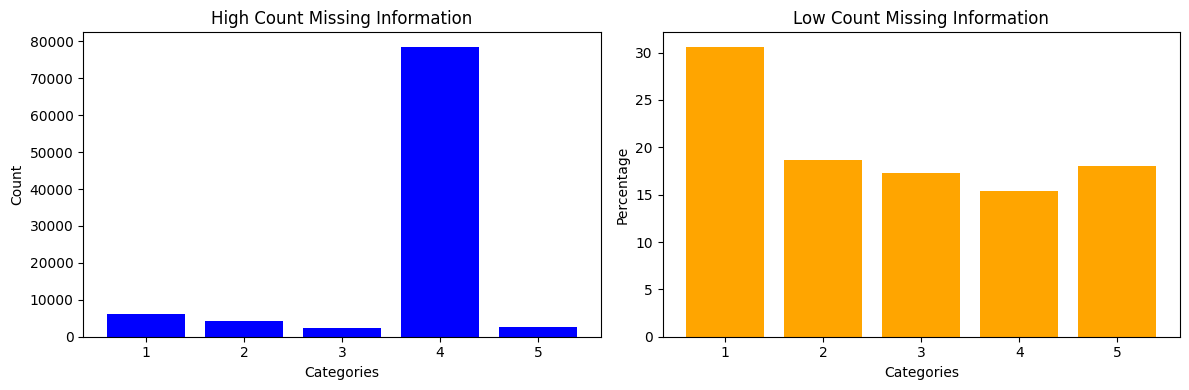

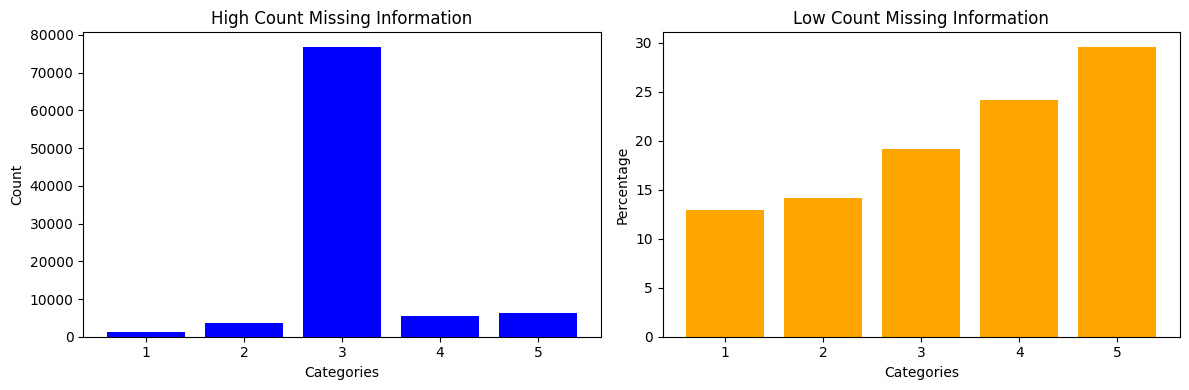

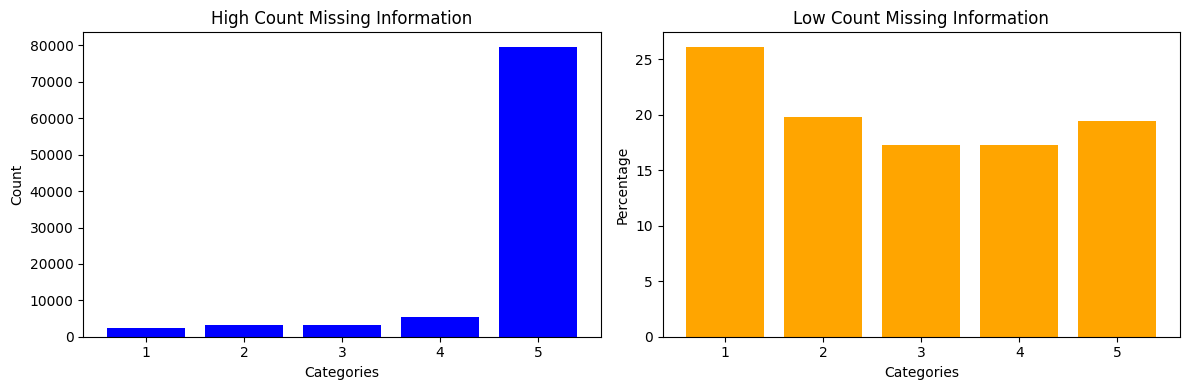

In [67]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for i in range(6):
    display_plots(column_missing_data[i])


#### Discussion 1.1.3: Assess Missing Data in Each Row

***Observation***

Is the data with lots of missing values qualitatively different from the data with few or no missing values? Yes ,the lower count is missing alot of data<br>

The data contain in the threshold which is below 30 some rows have a much higher percentage of data missing.  When you look at the graph with high count.  The pattern is of missing data is very evident but the lower threshold is missing alot of data.  The lower count is missing data which will make the EDA not great, so I will continute to analyst the data for the lower threshold.<br><br> Across all categories the  Lower threshold is missing information in all categories which require more investigation


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
# How many features are there of each data type?

feat_info.value_counts('type')

,count
type,
ordinal,49
categorical,21
mixed,7
numeric,7
interval,1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [69]:
# There are some missing values from  lower threshold data frame, if you dont remove will cause error, so let create an easy way to reference
missing_rows = ({
    'attribute': rows_lower_threshold.dtypes.index,
    'data_type': rows_lower_threshold.dtypes.values

})
rows_lower_threshold_dtypes = pd.DataFrame(missing_rows)
rows_lower_threshold_dtypes

,attribute,data_type
0,ALTERSKATEGORIE_GROB,float64
1,ANREDE_KZ,int64
2,CJT_GESAMTTYP,float64
3,FINANZ_MINIMALIST,int64
4,FINANZ_SPARER,int64
5,FINANZ_VORSORGER,int64
6,FINANZ_ANLEGER,int64
7,FINANZ_UNAUFFAELLIGER,int64
8,FINANZ_HAUSBAUER,int64
9,FINANZTYP,int64


In [70]:
#call function to separate out the categorical types using list comprehension
categorical_variables_df, binary_category, multi_level_category = find_categories(feat_info, azdias_demogrh_copy_df)

In [71]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Use list comprehension to keep code clean and easier to read
categorical_variables_df

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [72]:
#find the binary from categorical
binary_category

['ANREDE_KZ', 'GREEN_AVANTGARDE']

In [73]:
#find the multi level from categorical
multi_level_category

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [74]:
# create data frame so we can encode the mix values that have a count of less than 3 drop the other
# multi_cat_df = pd.DataFrame({
# 'Name': multi_level_category,
# 'Count': azdias_demogrh_copy_df[multi_level_category].nunique()
# }
# )

multi_cat_df = format_rows_missing_data(multi_level_category, azdias_demogrh_copy_df)
multi_cat_df['Count']

,Count
CJT_GESAMTTYP,6
FINANZTYP,6
GFK_URLAUBERTYP,12
LP_FAMILIE_FEIN,11
LP_FAMILIE_GROB,5
LP_STATUS_FEIN,10
LP_STATUS_GROB,5
NATIONALITAET_KZ,3
SHOPPER_TYP,4
SOHO_KZ,2


In [75]:
multi_cat_names_lt_3 =multi_cat_df[multi_cat_df['Count'] <3 ]

In [76]:
multi_cat_names_gt_3 = multi_cat_df[multi_cat_df['Count'] > 3 ]

In [77]:
print(multi_cat_names_lt_3)

                    Name  Count
SOHO_KZ          SOHO_KZ      2
VERS_TYP        VERS_TYP      2
OST_WEST_KZ  OST_WEST_KZ      2


In [78]:
multi_cat_names_lt_3['Name'].tolist()

['SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [79]:
print(multi_cat_names_gt_3)

                            Name  Count
CJT_GESAMTTYP      CJT_GESAMTTYP      6
FINANZTYP              FINANZTYP      6
GFK_URLAUBERTYP  GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN  LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB  LP_FAMILIE_GROB      5
LP_STATUS_FEIN    LP_STATUS_FEIN     10
LP_STATUS_GROB    LP_STATUS_GROB      5
SHOPPER_TYP          SHOPPER_TYP      4
ZABEOTYP                ZABEOTYP      6
GEBAEUDETYP          GEBAEUDETYP      7
CAMEO_DEUG_2015  CAMEO_DEUG_2015      9
CAMEO_DEU_2015    CAMEO_DEU_2015     44


In [80]:
name_multi_list = multi_cat_names_gt_3['Name'].tolist()

In [81]:
name_multi_list

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

**OBSERVATION**<br>
Keeping things straight forward going to **drop multi level category** where the count is greater than 3. On the multi level category where the count is less than 3 I will encode them with dummy variables:<br>

The following are being dropped from Lower Threshold and the Count of Missing Rows is included below:<br>
<ol>
<li>CJT_GESAMTTYP      CJT_GESAMTTYP      6</li>
<li>FINANZTYP              FINANZTYP      6</li>
<li>GFK_URLAUBERTYP  GFK_URLAUBERTYP     12</li>
<li>LP_FAMILIE_FEIN  LP_FAMILIE_FEIN     11</li>
<li>LP_FAMILIE_GROB  LP_FAMILIE_GROB      5</li>
<li>LP_STATUS_FEIN    LP_STATUS_FEIN     10</li>
<li>LP_STATUS_GROB    LP_STATUS_GROB      5</li>
<li>SHOPPER_TYP          SHOPPER_TYP      4</li>
<li>ZABEOTYP                ZABEOTYP      6</li>
<li>GEBAEUDETYP          GEBAEUDETYP      7</li>
<li>CAMEO_DEUG_2015  CAMEO_DEUG_2015      9</li>
<li>CAMEO_DEU_2015    CAMEO_DEU_2015     44</li>
</ol>
<br>
Cameo_DEU_2015 has alot of information missing which will SKEW the graph and can classified it really classified as an outlier in the data if kept.

#Lets find it inside below 20 dataframe,
#this was before deciding to drop keeping for record
rows_lower_threshold[rows_lower_threshold['CAMEO_DEU_2015'] == True]

In [82]:
#Going to drop it from rows below 20 dataframe
#Check for the label to see if it true, based off the index finding it, drop in place
rows_lower_threshold.drop(multi_cat_names_gt_3['Name'].tolist(),  inplace=True, axis=1)

In [83]:
rows_lower_threshold.reset_index(drop=True, inplace=True)

In [84]:
#Verify that other multi categories are still in list
rows_upper_threshold[multi_cat_names_gt_3['Name'].tolist()].head(6)

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,2.0,4,10.0,2.0,2.0,1.0,1.0,NaN,3,NaN,NaN,NaN
11,6.0,4,5.0,NaN,NaN,5.0,2.0,NaN,3,NaN,NaN,NaN
14,6.0,4,5.0,NaN,NaN,5.0,2.0,NaN,3,NaN,NaN,NaN
17,6.0,4,5.0,NaN,NaN,5.0,2.0,NaN,3,NaN,NaN,NaN
24,6.0,4,5.0,NaN,NaN,5.0,2.0,NaN,3,NaN,NaN,NaN
30,3.0,3,11.0,1.0,1.0,4.0,2.0,3.0,3,NaN,NaN,NaN


OBSERVATION

Create dummy variables for the multi level now since the remaining rows does not have a high volume of data missing.  Creating dummy variable instead of droping the data is the decision I made. Why the decision to use dummy variable since it is categorical variables, creating the dummy variables simipfies the dataset and make it easier to analyze. Another reason why I choose to use dummy variables is that when I start using a model it will understand the data better in my opinion.

In [85]:
rows_lower_threshold.shape

(797426, 67)

Old way of just keeping all multi and ecoding
rows_lt_20_subset = encoded_rows_with_dummies(rows_lt_20_subset, multi_level_category)

In [86]:
rows_lower_threshold = encoded_rows_with_dummies(rows_lower_threshold, multi_cat_names_lt_3['Name'] )

In [88]:
rows_lower_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,SOHO_KZ_1.0,VERS_TYP_2.0,OST_WEST_KZ_W
0,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,True,True,True
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,False,False,True
2,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,False,False,True
3,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,False,True,True
4,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,False,True,True


#### Discussion 1.2.1: Re-Encode Categorical Features

***OBSERVATION:**
<br>
Decided to drop the multilevel rows, to have a clear picture on doing the EDA.  I went thru the scenario of keeping all the data without dropping and the data was skewed. so I have dropped the multi level categorial for rows that is over the threshold and only keep the multi level rows that was less than 3 which is indicated below:

    Name            Count
<ul>                
<li>SOHO_KZ          SOHO_KZ      2</li>
<li>VERS_TYP        VERS_TYP      2</li>
<li>OST_WEST_KZ  OST_WEST_KZ      2</li>
</ul>  

For the user who has over lower level threshold rows or large volumn of data. Did not retain them

<ul> 
<li>CJT_GESAMTTYP      CJT_GESAMTTYP      6</li>
<li>FINANZTYP              FINANZTYP      6</li>
<li>GFK_URLAUBERTYP  GFK_URLAUBERTYP     12</li>
<li>LP_FAMILIE_FEIN  LP_FAMILIE_FEIN     11</li>
<li>LP_FAMILIE_GROB  LP_FAMILIE_GROB      5</li>
<li>LP_STATUS_FEIN    LP_STATUS_FEIN     10</li>
<li>LP_STATUS_GROB    LP_STATUS_GROB      5</li>
<li>SHOPPER_TYP          SHOPPER_TYP      4</li>
<li>ZABEOTYP                ZABEOTYP      6</li>
<li>GEBAEUDETYP          GEBAEUDETYP      7</li>
<li>CAMEO_DEUG_2015  CAMEO_DEUG_2015      9</li>
<li>CAMEO_DEU_2015    CAMEO_DEU_2015     44</li>
</ul>

I will do encoding on the Binary Catergory User that was capture and replace

<ol>
   <li>ANREDE_KZ </li>
   <li>GREEN_AVANTGARDE</li>
</ol>

The engineering steps I will perform on this task with is with get_dummies it is located in parse util files

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [60]:
rows_lower_threshold.shape

(797426, 67)

In [61]:
#lets find the row with this information
feat_info[feat_info['attribute']=='PRAEGENDE_JUGENDJAHRE']

,attribute,information_level,type,missing_or_unknown
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"


In [62]:
feat_info[feat_info['attribute']=='CAMEO_INTL_2015']

,attribute,information_level,type,missing_or_unknown
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [63]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
rows_lower_threshold['PRAEGENDE_JUGENDJAHRE'].head(6)


,PRAEGENDE_JUGENDJAHRE
0,14.0
1,15.0
2,8.0
3,8.0
4,3.0
5,10.0


In [64]:
#lets check out our decade series
DECADE

,0
1,40
2,40
3,50
4,50
5,60
6,60
7,60
8,70
9,70
10,80


In [132]:
#Lets encode PRAEGENDE_JUGENDJAHRE with row lt 20
#Create MOVEMENT VARIABLE , AND CALL METHOD TO ENCODE IT
rows_lower_threshold['MOVEMENT'] = rows_lower_threshold['PRAEGENDE_JUGENDJAHRE'].apply(search_music_styles)

In [133]:
rows_lower_threshold['MOVEMENT'].head()

,MOVEMENT
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0


In [134]:
# Now apply the decate
# CREATE DECADE VARIABLE  AND ENCODE IT
rows_lower_threshold['DECADE'] = rows_lower_threshold['PRAEGENDE_JUGENDJAHRE'].map(DECADE)

In [135]:
#Let look at dhe decade
rows_lower_threshold['DECADE'].head()

,DECADE
0,90.0
1,90.0
2,70.0
3,70.0
4,50.0


In [136]:
rows_lower_threshold =  create_feature_rows(rows_lower_threshold)

In [137]:
rows_lower_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,SOHO_KZ_1.0,VERS_TYP_2.0,OST_WEST_KZ_W,WEALTH,LIFESTAGE,MOVEMENT,DECADE
0,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,True,True,True,5.0,1.0,1.0,90.0
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,False,False,True,2.0,4.0,0.0,90.0
2,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,False,False,True,1.0,2.0,1.0,70.0
3,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,False,True,True,4.0,3.0,1.0,70.0
4,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,False,True,True,5.0,4.0,1.0,50.0


In [130]:
mixed_dtypes = pd.DataFrame(find_mixed_data_type_rows(feat_info, rows_lower_threshold))
mixed_dtypes

,0
0,LP_LEBENSPHASE_FEIN
1,LP_LEBENSPHASE_GROB
2,PRAEGENDE_JUGENDJAHRE
3,WOHNLAGE
4,CAMEO_INTL_2015
5,PLZ8_BAUMAX


In [71]:
mixed_data_type_rows = feat_info[feat_info['type'] == 'mixed']['attribute'].values
#now find the vales in row lt 20 data frame
mixed_data_type_rows = [n for n in mixed_data_type_rows if n in rows_lower_threshold.columns]
print(len(mixed_data_type_rows))

6


In [72]:
mixed_data_type_rows

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [142]:
# Found the 6 rows, that needs to ger dropped, dropping the mixed data type
rows_lower_threshold.drop(rows_lower_threshold, inplace=True, axis=1)
rows

191652

In [ ]:
rows_lower_threshold[rows_lower_threshold['LP_LEBENSPHASE_GROB'] == True].head()

In [143]:
rows_lower_threshold.shape

(797426, 0)

In [145]:
rows_lower_threshold.notna().all(axis=1).sum()

797426

#### Discussion 1.2.2: Engineer Mixed-Type Features

***Observation***

I engineer the Music styles into a dictionary for quick processing.<br>

During Observeration, I found 6 rows for the mix type in rows lower threshold, I was able to drop the mix values.<br>  I investigated CAMEO_INTL_2015 and it had lots of rows over 79707, Once I found the row, I was able to engineer another colum called CAMEO_INTL_2015_WEATH and feature engineer two additional columns name:<br>
<ol>
   <li> PRAEGENDE_JUGENDJAHRE_DECADE</li>
   <li>PRAEGENDE_JUGENDJAHRE</li>
</ol>

***Dropped from rows_lower_threshold***
I drop the mixed 6 rows that where found, I printed the length because printing out the values take up alot on output

<ol>
<li>LP_LEBENSPHASE_FEIN</li>
<li>LP_LEBENSPHASE_GROB</li>
<li>PRAEGENDE_JUGENDJAHRE</li>
<li>WOHNLAGE</li>
<li>CAMEO_INTL_2015</li>
<li>PLZ8_BAUMAX</li>
</ol>

RE Engineered
The PRAEGENDE_JUGENDJAHRE_DECADE was created by values from the Data Dictionary, where I create a Panda Series mapped to those value.

Reengineering Created:
<ul>
<li>From PRAEGENDE_JUGENDJAHRE</li>
    <ul>
    <li>MOVEMENT</li>
    <li>DECADE</li>
    </ul
</ul>

<ul>
<li>From CAMEO_INTL_2015</li>
    <ul>
    <li>WEALTH</li>
    <li>LIFESTAGE</li>
    </ul>
</ul>


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

feat_info[feat_info['attribute']=='PRAEGENDE_JUGENDJAHRE']

,attribute,information_level,type,missing_or_unknown
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"


In [76]:
feat_info[feat_info['attribute']=='CAMEO_INTL_2015']

,attribute,information_level,type,missing_or_unknown
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [146]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
rows_lower_threshold.isna().all(axis=1).sum()

797426

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [5]:
from parse_utils import find_columns_to_drop_over_threshold, find_rows_with_null_data_in_summary, \
    find_mixed_data_type_rows


def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # At the top of file we copy original Featuer Summary inot Summary Data
    feat_info = summary_df.copy()

    # summary_df =  replace_missing_data(feat_info, summary df)
    feature_summary_df  = replace_missing_data(feat_info, df)

    #Count the Columns create a panda dataframe containing, column, name, null count, percentages
    column_count_of_missing_df = find_columns_with_missing_data(feature_summary_df)

    #Find columns over percent threshold and columns to drop from list, threshold is set at 20
    # columns over threshold, not doing anything with it right now, only return columns to drop
    columns_over_threshold_percent, columns_to_drop =  find_columns_to_drop_over_threshold(column_count_of_missing_df, 30)

    # Drop the columns from summary based off of columns_to_drop and reset index on summary
    feature_summary_df.drop(columns=columns_to_drop, inplace=True, axis=1)
    feature_summary_df.reset_index(drop=True, inplace=True)

    #Find The missing rows and split summary returning upper and lower threshold
    rows_missing_from_summary = find_row_with_missing_data(feature_summary_df)      #use for graphs only
    rows_threshold_upper, rows_threshold_lower = split_dataset(feature_summary_df, rows_missing_from_summary, 30)

    # Find the rows that are missing in summary df
    # columns_missing_from_summary =  find_rows_with_null_data_in_summary(summary_df)  #used for grpahs only

    #  Find the categories, return as tuple for processing
    cat, binary, multi = find_categories(feat_info, feature_summary_df)

    #missing rows placd in a nice format
    multi_categorial_df = format_rows_missing_data(multi, feature_summary_df)

    #separate out the multi level that has less than 3
    multi_level_less_than_3 =  multi_categorial_df[ multi_categorial_df['Count'] <3 ]

    #We are going to drop these rows, contain a lot of missing data
    multi_level_greater_than_3 =  multi_categorial_df[ multi_categorial_df['Count'] >3 ]

    #drop lower therehold thats missing large volumes
    rows_threshold_lower.drop(multi_level_greater_than_3['Name'].tolist(),  inplace=True, axis=1)
    rows_threshold_lower.reset_index(drop=True, inplace=True)

    #Lower threshold drop the rows where its CAMEO_DEU_215
    # Encode with  dummy variables call encoded_rows_with_dummies
    rows_threshold_lower = encoded_rows_with_dummies(rows_threshold_lower,  multi_level_less_than_3['Name'])
    rows_threshold_lower.reset_index(drop=True, inplace=True)


    # Feature Engineering on PRAEGENDE_JUGENDJAHRE creating Movement and Decade Columns
    rows_threshold_lower['MOVEMENT'] = rows_threshold_lower['PRAEGENDE_JUGENDJAHRE'].apply(search_music_styles)
    rows_threshold_lower['DECADE'] =  rows_threshold_lower['PRAEGENDE_JUGENDJAHRE'].map(DECADE)

    # FeatureEngineering on CAMEO_INTL_2015'
    rows_threshold_lower = create_feature_rows(rows_threshold_lower)

    # Find the mix data type rows
    mixed_data_type_rows = find_mixed_data_type_rows(feat_info, rows_threshold_lower)

    # Drop the mix data type rows  from  rows_threshold_lower
    rows_threshold_lower.drop(mixed_data_type_rows, inplace=True, axis=1)
    rows_threshold_lower.reset_index(drop=True, inplace=True)

    #Process Rows that are null and set threshld, return only number, which will eliminate object  data types that missing data
    return rows_threshold_lower.select_dtypes(include='number')


In [6]:
# Load in the feature summary file.
# general_demo_df = azdias_demogrh_df.copy()
# summary_df = feat_info.copy
# customer_demo_df = cst_demogrh_df.copy()
test_general_demo_df = general_demo_df.copy()
clean_data_df = clean_data(test_general_demo_df)
clean_data_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFESTAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,90.0,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0.0,90.0,2.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,1.0,70.0,1.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,1.0,70.0,4.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,1.0,50.0,5.0,4.0


In [7]:
clean_data_df.shape

(798067, 62)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [8]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#lets check again for null values
print(check_null_types(clean_data_df))

dtype
int64           0
float64    760582
Name: null_count, dtype: int64


In [9]:
#Impute missing values
constant_imputer = SimpleImputer(strategy='constant', fill_value=0)
clean_data_df = clean_data_df.reindex(sorted(clean_data_df.columns), axis=1)

imputed_rows = constant_imputer.fit_transform(clean_data_df)

print(f'\n Imputed Rows:\n {imputed_rows}')



 Imputed Rows:
 [[ 1.  2. 11. ...  5.  9.  3.]
 [ 3.  2. 10. ...  2.  9.  3.]
 [ 4.  2.  1. ...  1.  9.  0.]
 ...
 [ 2.  2.  3. ...  2.  5.  0.]
 [ 1.  1.  7. ...  5.  9.  1.]
 [ 4.  1. 10. ...  4.  3.  6.]]


In [10]:
#convert back to panda data frame
imputed_clean_df = pd.DataFrame(imputed_rows, columns=clean_data_df.columns)
imputed_clean_df.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,DECADE,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,KBA13_ANZAHL_PKW,KKK,KONSUMNAEHE,LIFESTAGE,MIN_GEBAEUDEJAHR,MOBI_REGIO,MOVEMENT,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,WEALTH,WOHNDAUER_2008,W_KEIT_KIND_HH
0,1.0,2.0,11.0,0.0,2.0,0.0,3.0,6.0,90.0,3.0,5.0,5.0,1.0,5.0,4.0,2.0,3.0,0.0,3.0,6.0,8.0,0.0,0.0,0.0,2.0,1.0,963.0,2.0,1.0,1.0,1992.0,1.0,1.0,1.0,3.0,5.0,2.0,3.0,2.0,1.0,4.0,5.0,3.0,4.0,1.0,7.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,5.0,9.0,3.0
1,3.0,2.0,10.0,0.0,1.0,0.0,3.0,2.0,90.0,4.0,2.0,5.0,1.0,4.0,3.0,1.0,4.0,1.0,3.0,4.0,4.0,1.0,3.0,1.0,0.0,3.0,712.0,2.0,5.0,4.0,1992.0,3.0,0.0,1.0,2.0,5.0,3.0,3.0,1.0,0.0,4.0,4.0,2.0,2.0,3.0,7.0,6.0,1.0,7.0,7.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,9.0,3.0


In [13]:
print(check_null_types(imputed_clean_df))

dtype
float64    0
Name: null_count, dtype: int64


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
imputed_clean_df = pd.DataFrame(scaler.fit_transform(imputed_clean_df), columns=imputed_clean_df.columns)
imputed_clean_df.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,DECADE,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,KBA13_ANZAHL_PKW,KKK,KONSUMNAEHE,LIFESTAGE,MIN_GEBAEUDEJAHR,MOBI_REGIO,MOVEMENT,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,WEALTH,WOHNDAUER_2008,W_KEIT_KIND_HH
0,-1.733620,0.957912,0.173578,-0.125133,0.234458,-0.060408,-0.146602,0.846379,0.976547,-0.543805,1.465965,1.339319,-1.494594,1.53792,0.958633,-1.040686,-0.799647,-0.530407,1.03738,1.026720,1.699798,-1.008836,-0.965690,-0.594874,2.730674,-1.361946,1.020301,-0.418783,-1.304352,-1.233517,-0.383167,-1.181370,0.585967,-0.228174,0.180987,-0.114246,-0.181868,0.274028,0.447384,0.442535,0.581457,1.313574,-0.517207,0.687387,-1.643491,1.339262,-1.435372,-0.059355,-0.157565,-0.312196,-0.578164,-1.109913,-0.463909,1.518699,1.274185,0.002834,0.443205,1.288987,-1.684507,1.186055,0.567332,-0.419956
1,0.208165,0.957912,0.109591,-0.125133,-0.630198,-0.060408,-0.146602,-0.983592,0.976547,0.037019,-0.570999,1.339319,-1.494594,0.86456,0.244109,-1.766972,0.283483,1.885345,1.03738,-0.267573,-0.268761,-0.297919,1.444756,0.408133,-0.464084,0.000276,0.295063,-0.418783,1.274782,0.766016,-0.383167,0.120865,-1.706581,-0.228174,-0.457889,-0.114246,0.788768,0.274028,-0.543992,-0.934791,0.581457,0.433713,-0.983852,-0.767040,-0.286701,1.339262,0.754262,-1.626994,1.448745,1.391992,-0.578164,-0.158741,-0.463909,-0.638942,0.064233,-0.520587,-0.072013,-0.410210,-0.142554,-0.831911,0.567332,-0.419956


### Discussion 2.1: Apply Feature Scaling

Observation:

Using the StandardScaler, and viewing the elements. The values are close to 0 and before applying the scaler. This is going to make doing the analyst on the graph easier to read and provide for a better analysis. 

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [12]:
# Apply PCA to the data.
#pca return numpy array
pca = PCA()
imputed_clean_df =  pca.fit_transform(imputed_clean_df)


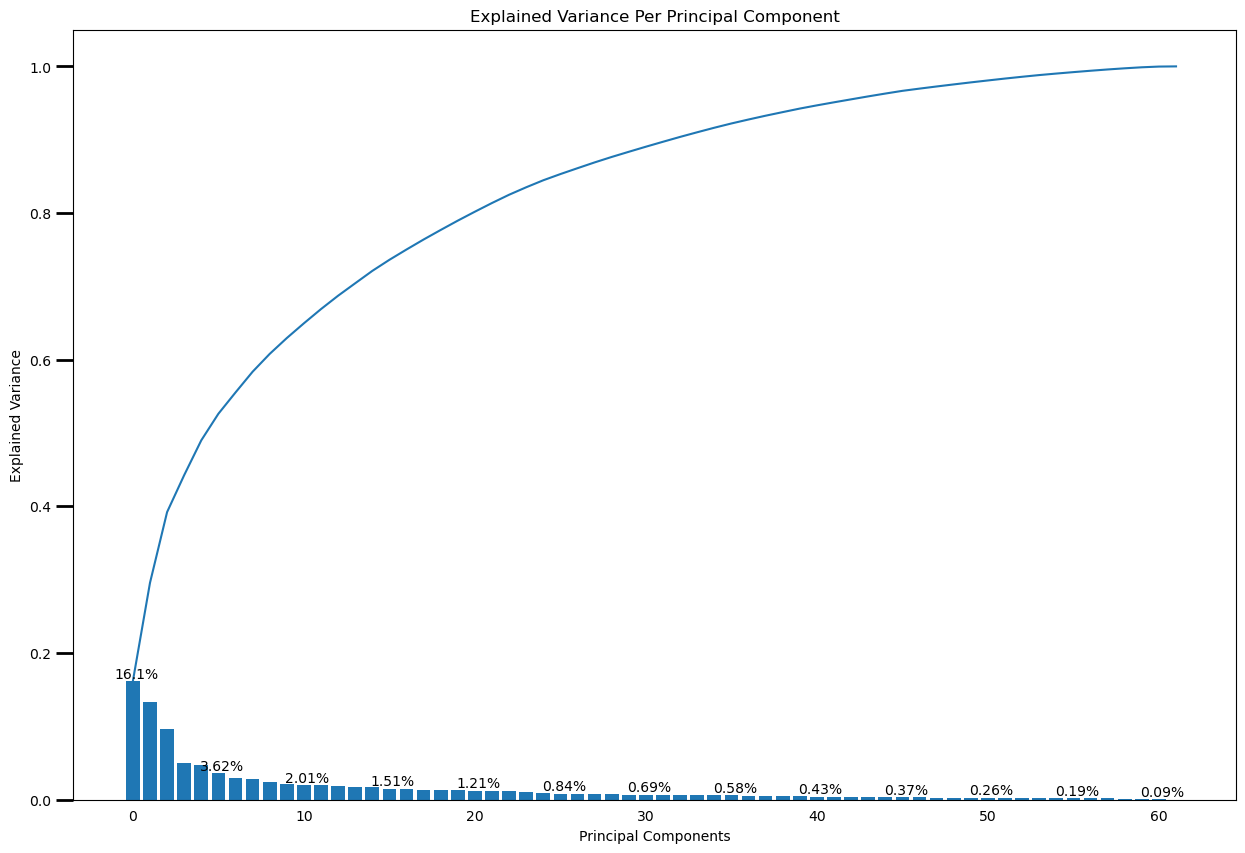

In [14]:
scree_plot(pca)

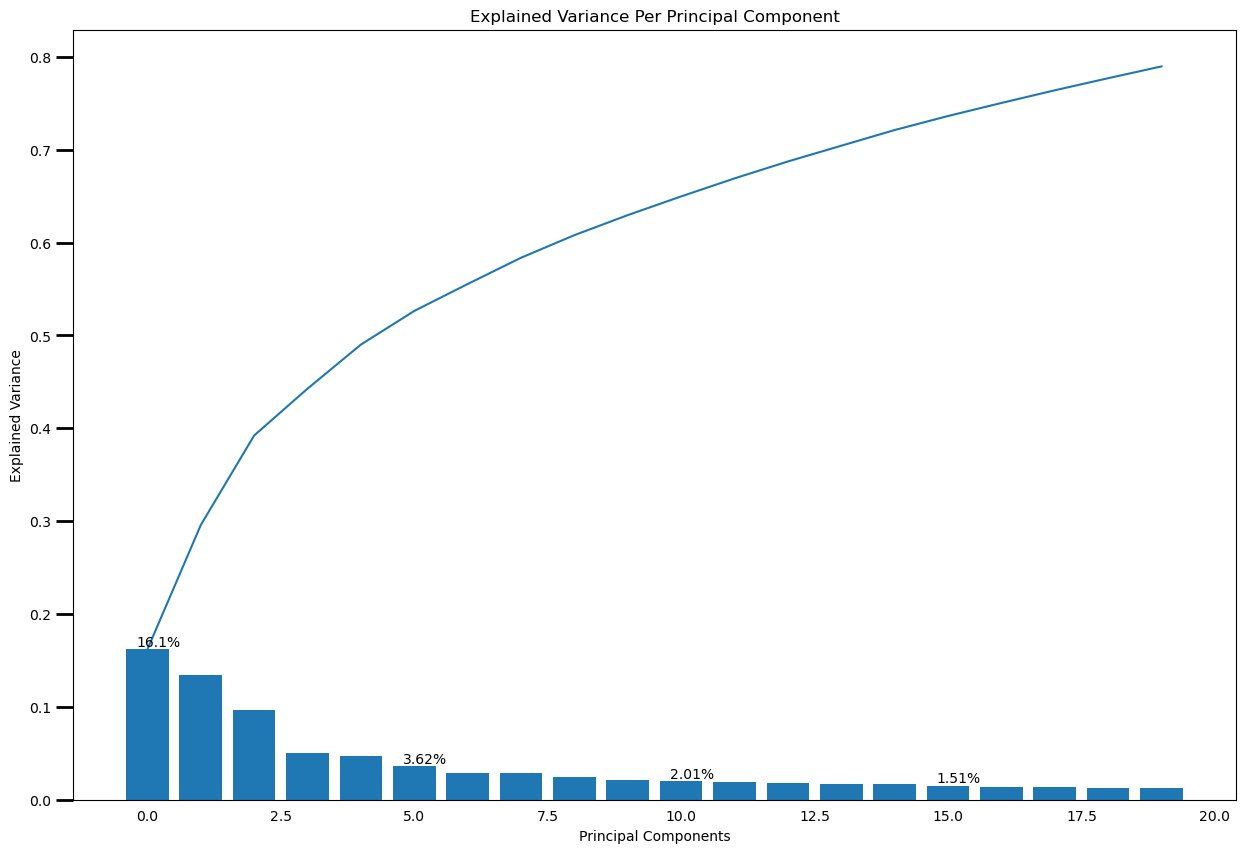

In [13]:
# Re-apply PCA to the data while selecting for number of components to retain
#40 components to keep
pca = PCA(n_components=20)
clean_reduce_pca = pca.fit_transform(imputed_clean_df)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction
***Observation:***<br>
I have decided to keep components 20 components after analyzing the curve. I see that the first 20 components contain 80% of the variance.  When you look at the curve in the graph the first 5 components capture alot of the information.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [18]:
# A quick and dirty sort
sorted_df=sort_pca_by_weights(clean_data_df, pca, 3)
print(sorted_df.head(25))

ANZ_HH_TITEL             1.000000e+00
ANZ_TITEL                6.071720e-16
FINANZ_MINIMALIST        5.348880e-16
ANREDE_KZ                3.885781e-16
SEMIO_FAM                3.370674e-16
PLZ8_HHZ                 2.846510e-16
FINANZ_ANLEGER           2.748796e-16
SEMIO_TRADV              2.584738e-16
MOVEMENT                 2.324649e-16
SEMIO_SOZ                2.099015e-16
DECADE                   1.885884e-16
RETOURTYP_BK_S           1.863925e-16
PLZ8_ANTG2               1.715822e-16
GREEN_AVANTGARDE         1.516675e-16
SEMIO_KULT               1.426810e-16
KBA05_ANTG4              1.337120e-16
FINANZ_UNAUFFAELLIGER    1.303310e-16
MOBI_REGIO               1.214603e-16
PLZ8_GBZ                 1.154956e-16
LIFESTAGE                1.108686e-16
WEALTH                   1.072276e-16
KONSUMNAEHE              1.019888e-16
SEMIO_REL                7.459311e-17
RELAT_AB                 4.980004e-17
MIN_GEBAEUDEJAHR         4.844384e-17
Name: 3, dtype: float64


In [21]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
sorted_df = first_pc_analysis(clean_data_df, pca, 0)
print(sorted_df.head(25))

                  Feature        Weight
0    ALTERSKATEGORIE_GROB  1.000000e+00
7                BALLRAUM  2.439860e-16
24            KBA05_ANTG4  1.460609e-16
12      FINANZ_MINIMALIST  1.043695e-16
5               ANZ_TITEL  1.040506e-16
25              KBA05_GBZ  9.827956e-17
3            ANZ_HH_TITEL  8.005220e-17
56              SEMIO_SOZ  6.967140e-17
16     GEBAEUDETYP_RASTER  6.368898e-17
26       KBA13_ANZAHL_PKW  5.389555e-17
31             MOBI_REGIO  5.100342e-17
58             SEMIO_VERT  4.781267e-17
39             PLZ8_ANTG4  4.656700e-17
50             SEMIO_KULT  3.337204e-17
51             SEMIO_LUST  2.119129e-17
14  FINANZ_UNAUFFAELLIGER  1.652772e-17
33       NATIONALITAET_KZ  1.420332e-17
52              SEMIO_MAT  1.415250e-17
35            ORTSGR_KLS9  1.312685e-17
17       GREEN_AVANTGARDE  1.247925e-17
36             PLZ8_ANTG1  1.094157e-17
4            ANZ_PERSONEN  8.610368e-18
60         WOHNDAUER_2008  6.825474e-18
54              SEMIO_RAT  2.856225e-18


In [19]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sorted_df = first_pc_analysis(clean_data_df, pca,2)
print(sorted_df)

                  Feature        Weight
2     ANZ_HAUSHALTE_AKTIV  1.000000e+00
0    ALTERSKATEGORIE_GROB  7.863556e-16
7                BALLRAUM  6.159313e-16
4            ANZ_PERSONEN  4.737077e-16
3            ANZ_HH_TITEL  3.936422e-16
43               RELAT_AB  2.923720e-16
56              SEMIO_SOZ  2.775558e-16
5               ANZ_TITEL  2.371654e-16
25              KBA05_GBZ  2.262340e-16
54              SEMIO_RAT  1.806281e-16
26       KBA13_ANZAHL_PKW  1.773218e-16
46              SEMIO_ERL  1.524965e-16
60         WOHNDAUER_2008  1.448494e-16
28            KONSUMNAEHE  1.396119e-16
48             SEMIO_KAEM  1.332975e-16
36             PLZ8_ANTG1  1.222357e-16
49             SEMIO_KRIT  1.144917e-16
14  FINANZ_UNAUFFAELLIGER  1.076030e-16
12      FINANZ_MINIMALIST  9.462669e-17
13          FINANZ_SPARER  9.070663e-17
38             PLZ8_ANTG3  9.057846e-17
53          SEMIO_PFLICHT  8.153200e-17
24            KBA05_ANTG4  6.781073e-17
22            KBA05_ANTG2  4.961874e-17


In [17]:
sorted_df = first_pc_analysis(clean_data_df, pca,3)
print(sorted_df)

                  Feature        Weight
3            ANZ_HH_TITEL  1.000000e+00
5               ANZ_TITEL  6.071720e-16
12      FINANZ_MINIMALIST  5.348880e-16
1               ANREDE_KZ  3.885781e-16
47              SEMIO_FAM  3.370674e-16
41               PLZ8_HHZ  2.846510e-16
10         FINANZ_ANLEGER  2.748796e-16
57            SEMIO_TRADV  2.584738e-16
32               MOVEMENT  2.324649e-16
56              SEMIO_SOZ  2.099015e-16
8                  DECADE  1.885884e-16
44         RETOURTYP_BK_S  1.863925e-16
37             PLZ8_ANTG2  1.715822e-16
17       GREEN_AVANTGARDE  1.516675e-16
50             SEMIO_KULT  1.426810e-16
24            KBA05_ANTG4  1.337120e-16
14  FINANZ_UNAUFFAELLIGER  1.303310e-16
31             MOBI_REGIO  1.214603e-16
40               PLZ8_GBZ  1.154956e-16
29              LIFESTAGE  1.108686e-16
59                 WEALTH  1.072276e-16
28            KONSUMNAEHE  1.019888e-16
55              SEMIO_REL  7.459311e-17
43               RELAT_AB  4.980004e-17


### Observation

Correlationship that exists between showing prominent features and their relationships, and what a positive or negative value on the principal component might indicate
<br>

***On fhr First Principal Component***
<ul>
<li>1: unknown (missing)
<li>0: unknown (cannot be determined)
<li>1: < 30 years old
<li>2: 30 - 45 years old
<li>3: 46 - 60 years old
<li>4: > 60 years old
<li>9: uniformly distributed
<li>1: unknown (missing)</li>
<li>0: unknown (cannot be determined)</li>
<li>1: male</li>
<li>2: female</li>
</ul>
<br>
    
***Positive:***
<ul>
<li>ALTERSKATEGORIE_GROB &nbsp&nbsp 1.000000e+00</li>
    <ul>
        <li>
           Estimated age based on given name analysis:
        <ul>
           <li>2:30 - 45 years old</li>
        </ul>
        </li>
    </ul>
</ul>
<br>
    
***Negative***
<ul>
<li>ANREDE_KZ &nbsp&nbsp -1.332268e-15</li>
    <ul>
        <li>
         Gender:
            <ul>
             <li>Female</li>
            </ul>
        </li>
    </ul>
</ul>
<br>
    
***Second Principal Compononet***
<ul>
    <li>Number of housholds in the building</li>
    <li>Number of 1-2 family houses in the microcell</li>
    <ul>
    <li>1: unknown</li>
    <li>0: no 1-2 family homes</li>
    <li>1: lower share of 1-2 family homes</li>
    <li>2: average share of 1-2 family homes</li>
    <li>3: high share of 1-2 family homes</li>
    <li>4: very high share of 1-2 family homes</li>
    </ul>
</ul>

***Positive***
<ul>
<li>ANZ_HAUSHALTE_AKTIV &nbsp&nbsp 1.000000e+00</li>
    <ul>
        <li>
            Number of households in the building
        </li>
    </ul>
</ul>
<br>

***Negative***
<ul>
<li>KBA05_ANTG1 &nbsp&nbsp -2.776161e-16</li>
    <ul>
        <li>
            Number of 1-2 family houses in the microcell
            <ul>
            <li>Lower share of 1-2 family homes</li>
            </ul>
        </li>
    </ul>
</ul>
<br>

***On Third Principal Component***
<ul>
<li>Number of professional academic title holders in building</li>
<li>Personality typology, for each dimension:</li>
<li>1: unknown</li>
<li>1: highest affinity</li>
<li>2: very high affinity</li>
<li>3: high affinity</li>
<li>4: average affinity</li>
<li>5: low affinity</li>
<li>6: very low affinity</li>
<li>7: lowest affinity</li>
<li>9: unknown</li>
</ul>

***Positive Relationship***
<ul>
<li>ANZ_HH_TITEL  &nbsp&nbsp  1.000000e+00</li> 
    <ul>
        <li>Number of professional academic title holders in building</li>
    </ul>
</ul> 

***Negative Relationhop***
<ul>
<li>SEMIO_DOM &nbsp&nbsp -4.629931e-16</li>
    <ul>
        <li>Personality typology</li>
        <ul>
            <li>
                lowest affinity
            </li>
        </ul>
    </ul>
</ul>





## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [24]:
def find_kmean_score(data, center):
    kmeans = KMeans(n_clusters=center) #create the number of clusters
    model = kmeans.fit(data)  # fit the model to your data
    score = np.abs(np.mean(model.score(data)))  #obtain a score
    return score


In [52]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
k_count = np.arange(1,12)
k_cluster = {f'Cluster{ i }': find_kmean_score(clean_reduce_pca, i) for i in range(1,12) }
# k_count = len(k_cluster)
for k, v in k_cluster.items():
    print(k, v)

Cluster1 39073208.86834086
Cluster2 33135120.690551095
Cluster3 29842591.317102388
Cluster4 28015891.011114243
Cluster5 26592972.97318677
Cluster6 25310375.03293673
Cluster7 24105281.367885493
Cluster8 23570456.843909733
Cluster9 22563758.71103715
Cluster10 22078831.077424098
Cluster11 21483195.40877267


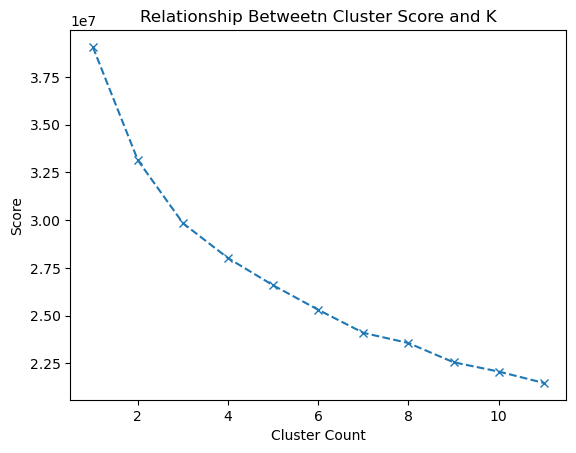

In [53]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(k_count, k_cluster.values(), marker='x', linestyle='--')
plt.xlabel('Cluster Count')
plt.ylabel('Score')
plt.title('Relationship Betweetn Cluster Score and K')
plt.show()

In [23]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k_refit = KMeans(n_clusters=10)
general_predict = k_refit.fit_predict(clean_reduce_pca)
general_predict

array([7, 2, 2, ..., 9, 5, 6], dtype=int32)

In [24]:
general_predict_df = pd.DataFrame(general_predict)
general_predict_df.head()

,0
0,7
1,2
2,2
3,6
4,9


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

***Observation:***
<br>
Analyzing the graph shows how the average distance decrease in the cluster, I used 30 as my first test for the maximum number of cluster to verify the average distance was decreasing, After analyzing the scree graph, the turning point in the curve starts at 8 clustoer. A ***Seven Cluster***  segment for customer population is the best fit according to the elbow method.  At 8 Cluster the rate of improvement starts to diminish.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [25]:
# Load in the customer demographics data.
customer_demogrh_df  = customer_demo_df.copy()
# customer_demogrh_df  = customer_demogrh_df.reindex(sorted(customer_demogrh_df.columns), axis=1)
#lets check again for null values

In [26]:
customer_data_df = clean_data(customer_demogrh_df)

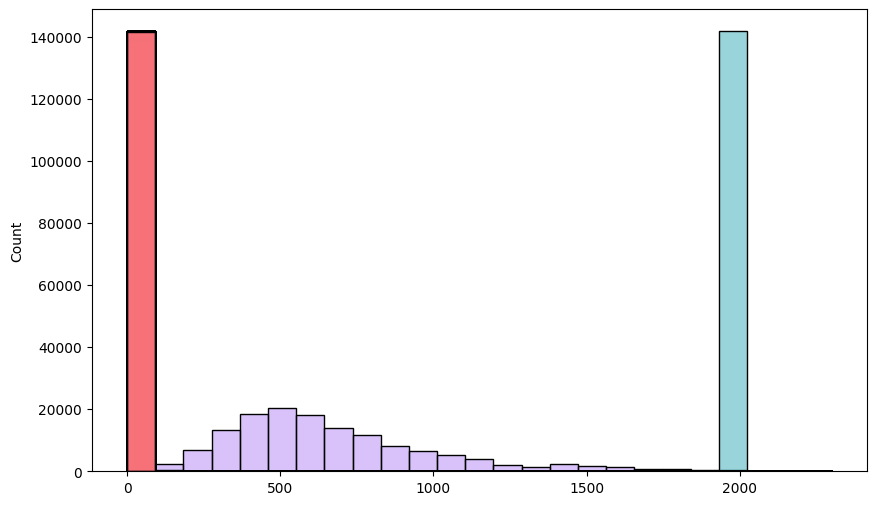

In [27]:
plt.figure(figsize=(10,6))
sns.histplot(customer_data_df, bins=25)
plt.legend([],[], frameon=False)
plt.show()

In [28]:
# Load in the feature summary file.
# Load the Demographics for customer mail-order
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
print(check_null_types(customer_data_df))

dtype
int64          0
float64    85005
Name: null_count, dtype: int64


In [29]:
customer_data_df.shape

(141771, 60)

In [31]:
for col in constant_imputer.feature_names_in_:
    if col not in customer_data_df.columns:
        customer_data_df[col] = 0

In [32]:
customer_data = customer_data_df[constant_imputer.feature_names_in_]

In [33]:
#Impute Customer Data
customer_data = constant_imputer.transform(customer_data)

In [34]:
#Normalize the data with StandardScaler
customer_data = scaler.transform(customer_data)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [38]:
verified_customer_data = pd.DataFrame(customer_data, columns=customer_data_df.columns)
verified_customer_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFESTAGE,KKK,REGIOTYP
0,1.179057,-1.043937,-0.466294,-0.125133,0.234458,-0.060408,-2.102427,-0.526099,-1.045083,-1.124628,-1.249987,-0.791197,1.409058,-1.155519,-0.470414,1.138172,0.283483,1.885345,-1.262339,-2.209012,-0.268761,0.412997,0.641274,-0.594874,-0.464084,0.681386,1.707978,-2.08764,1.274782,0.099505,-0.383167,0.771983,-1.706581,-0.228174,0.180987,-1.402593,0.788768,0.274028,-0.543992,-0.934791,1.391416,1.313574,-1.917141,-1.494254,1.070089,-1.946346,-0.887964,0.463191,-1.763875,-0.880259,-0.067376,1.268018,1.104148,-1.178352,-1.750696,-1.044008,0.958423,-1.543009,0.885415,-1.504567,0.567332,1.057947
1,1.179057,0.957912,-0.466294,-0.125133,-0.630198,-0.060408,-0.146602,1.303872,-1.045083,0.037019,-1.249987,0.629147,1.409058,-1.155519,0.958633,1.138172,-0.799647,1.885345,-0.112479,-2.209012,-1.745181,0.412997,0.641274,-0.594874,-0.464084,0.000276,-0.511079,-2.08764,-1.304352,0.766016,-0.383167,0.120865,-1.706581,-0.228174,-1.096764,-0.114246,-0.181868,0.274028,1.438760,0.442535,-1.038461,-0.446148,-1.917141,-0.039827,1.070089,0.244059,1.301671,-1.104448,0.913309,1.391992,-1.599741,1.268018,-0.463909,-0.099532,-1.145720,-1.567429,-1.102449,-1.543009,-0.656538,-0.159256,0.567332,1.057947
2,1.179057,-1.043937,-0.530281,-0.125133,-1.494855,-0.060408,-2.102427,1.303872,-1.550491,-1.705451,-0.570999,-0.791197,1.409058,-1.155519,-1.184938,1.138172,0.283483,-0.530407,-0.112479,-0.267573,1.207659,1.123914,-0.965690,-0.594874,-0.464084,0.681386,0.419307,-2.08764,-0.659568,0.766016,-0.383167,0.771983,0.585967,-0.228174,-0.457889,-0.973144,0.788768,-0.704090,-0.543992,-0.934791,0.581457,-0.446148,-1.917141,-1.494254,-0.286701,-0.851143,-0.887964,0.463191,-0.693002,-0.880259,-0.067376,0.316845,0.058776,-0.638942,-0.540743,-0.520587,0.958423,0.156189,1.399399,-0.831911,0.567332,-1.897859
3,0.208165,-1.043937,-0.082371,-0.125133,1.963772,-0.060408,-0.146602,-0.526099,-0.034268,0.037019,0.786977,-0.791197,-0.042768,-1.155519,1.673157,0.411886,-0.799647,-0.530407,1.037380,1.026720,-0.268761,-1.008836,1.444756,1.411140,-0.464084,0.000276,-0.279927,-2.08764,-1.304352,-1.233517,-0.383167,0.120865,0.585967,-0.228174,1.458738,-0.114246,-0.181868,1.252145,0.447384,0.442535,-0.228502,-0.446148,-1.917141,-1.494254,1.070089,0.244059,-0.340555,0.463191,-1.228438,-0.880259,0.443412,0.792432,1.104148,0.439879,0.669209,0.002834,-0.072013,0.156189,0.371431,0.513399,0.567332,-0.912590
4,0.208165,-1.043937,-0.466294,-0.125133,0.234458,-0.060408,-0.146602,1.303872,-1.045083,0.617842,-1.249987,-0.081025,1.409058,-1.155519,-0.470414,1.138172,0.283483,1.885345,1.037380,-2.209012,1.699798,0.412997,0.641274,0.408133,-0.464084,0.000276,1.609738,-2.08764,-0.659568,0.766016,-0.383167,0.120865,-1.706581,-0.228174,0.180987,0.744651,-0.181868,0.274028,0.447384,0.442535,1.391416,1.313574,-1.917141,1.414600,-0.286701,0.244059,-0.340555,-0.059355,-0.693002,0.255867,0.954200,0.792432,-1.509281,-0.638942,-1.145720,0.002834,0.958423,0.156189,1.399399,-0.159256,0.567332,1.057947


In [35]:
customer_data.shape

(141771, 62)

In [39]:
#Apply PCA - Principal Component Analysis
customer_data = pca.transform(verified_customer_data)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [40]:
#Kmeans
customer_pred = k_refit.predict(customer_data)
customer_pred

array([1, 1, 1, ..., 1, 3, 0], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [49]:
def plot_customer_demo(general_data, customer_data):
    figure, axes = plt.subplots(figsize=(20,10), ncols=2)

    #Select unique values from general and customer data
    x_gen, y_gen = np.unique(general_data, return_counts=True)
    x_cust, y_cust = np.unique(customer_data, return_counts=True)

    #Do division to make the y value height is with in limits
    y_gen = y_gen/len(general_data)
    y_cust= y_cust/len(customer_data)

    plt.subplot(1,2,1)
    plt.bar(x_gen, y_gen)
    plt.title('General Population')

    plt.subplot(1,2,2)
    plt.bar(x_cust, y_cust)
    plt.title('Customer Data')
    plt.show


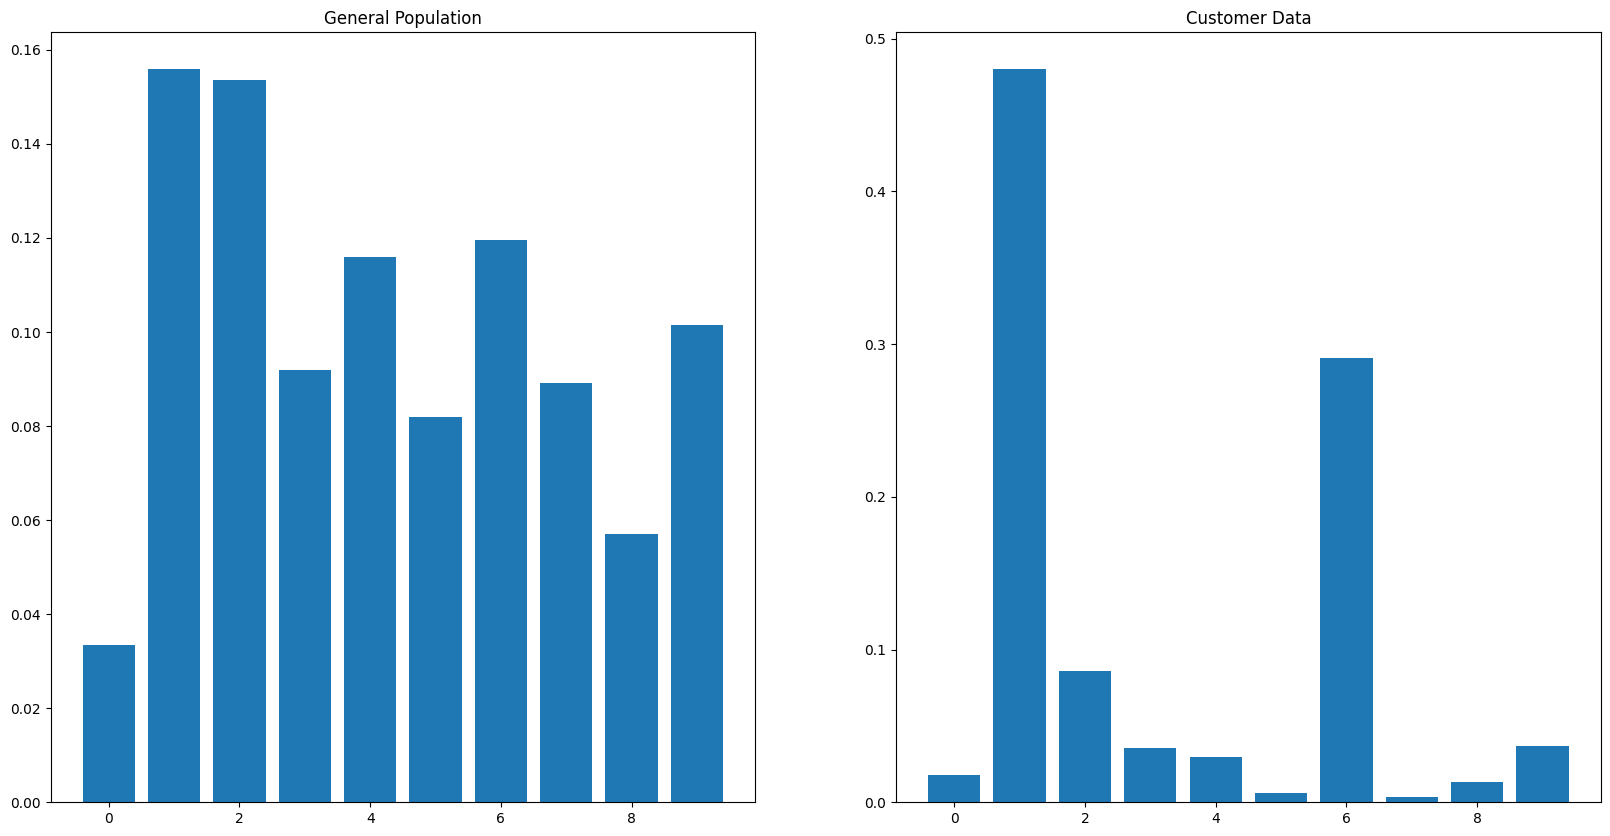

In [50]:
plot_customer_demo(general_predict, customer_pred)

In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# In Customer Dataset Customers in Custer 1 are overrated

overrepresented = scaler.inverse_transform(pca.inverse_transform(k_refit.cluster_centers_[1].reshape(1,-1)))
overrepresented

array([[ 6.29386741e+00,  1.74439482e+00, -2.56534569e+01,
         6.02907243e-02,  1.64457127e+00, -7.75541274e-03,
         3.18512704e+00,  4.65026889e+00,  6.86491452e+01,
         3.79630130e+00,  2.80244601e+00,  3.01371086e+00,
         3.04097776e+00,  2.53901525e+00,  2.65603273e+00,
         3.42265789e+00,  3.68299913e+00,  1.91431830e-01,
         2.08792411e+00,  4.41512580e+00,  4.54610703e+00,
         1.41906381e+00,  1.20188155e+00,  5.93090555e-01,
         2.90528239e-01,  2.99959527e+00,  6.09880896e+02,
         2.50188017e+00,  3.02293041e+00,  2.85070802e+00,
         1.99327691e+03,  2.81437273e+00,  7.44403665e-01,
         1.11885969e+00,  2.71671050e+00,  5.26603030e+00,
         2.18737023e+00,  2.71984182e+00,  1.54872461e+00,
         6.78699909e-01,  3.28211541e+00,  3.50706645e+00,
         4.10835306e+00,  3.05476608e+00,  3.42261615e+00,
         4.55431186e+00,  4.62212195e+00,  4.11358821e+00,
         4.29427354e+00,  4.54958042e+00,  4.13190622e+0

In [68]:
#Convert to Dataframe to see customer in cluster
overrepresented = pd.DataFrame(overrepresented, columns=customer_data_df.columns)
overrepresented.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFESTAGE,KKK,REGIOTYP
0,6.293867,1.744395,-25.653457,0.060291,1.644571,-0.007755,3.185127,4.650269,68.649145,3.796301,2.802446,3.013711,3.040978,2.539015,2.656033,3.422658,3.682999,0.191432,2.087924,4.415126,4.546107,1.419064,1.201882,0.593091,0.290528,2.999595,609.880896,2.50188,3.02293,2.850708,1993.276914,2.814373,0.744404,1.11886,2.716711,5.26603,2.18737,2.719842,1.548725,0.6787,3.282115,3.507066,4.108353,3.054766,3.422616,4.554312,4.622122,4.113588,4.294274,4.54958,4.131906,4.333779,3.88755,4.18452,3.893826,3.994586,4.139771,3.724242,4.27735,3.236757,7.908934,3.85247


In [69]:
overrepresented= first_pc_analysis(overrepresented, pca, 3)
overrepresented.head()

,Feature,Weight
0,FINANZ_SPARER,1.000000e+00
1,FINANZ_VORSORGER,-4.398116e-15
2,GREEN_AVANTGARDE,9.566791e-16
3,SEMIO_SOZ,6.173453e-16
4,FINANZ_UNAUFFAELLIGER,-5.456476e-16


In [78]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented = scaler.inverse_transform(pca.inverse_transform(k_refit.cluster_centers_[5].reshape(1,-1)))
underrepresented

array([[-1.62091666e+00,  2.81598220e+00, -2.88831197e+01,
         2.59140948e-02,  1.49404698e+00, -2.59132941e-03,
         3.34653398e+00,  4.54897613e+00,  7.70744587e+01,
         4.40765561e+00,  2.51415787e+00,  3.33358398e+00,
         2.95145429e+00,  3.05396250e+00,  2.72402182e+00,
         3.46372286e+00,  3.68400724e+00,  2.57119105e-01,
         2.02866037e+00,  4.44610796e+00,  4.54610703e+00,
         1.41906381e+00,  1.20188155e+00,  5.93090555e-01,
         2.90528239e-01,  2.99959527e+00,  6.09880896e+02,
         2.50188017e+00,  3.02293041e+00,  2.85070802e+00,
         1.99327691e+03,  2.81437273e+00,  7.44403665e-01,
         1.11885969e+00,  2.71671050e+00,  5.26603030e+00,
         2.18737023e+00,  2.71984182e+00,  1.54872461e+00,
         6.78699909e-01,  3.28211541e+00,  3.50706645e+00,
         4.10835306e+00,  3.05476608e+00,  3.42261615e+00,
         4.55431186e+00,  4.62212195e+00,  4.11358821e+00,
         4.29427354e+00,  4.54958042e+00,  4.13190622e+0

In [79]:
#Convert to DataFrame
underrepresented = pd.DataFrame(underrepresented, columns=customer_data_df.columns)
underrepresented.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFESTAGE,KKK,REGIOTYP
0,-1.620917,2.815982,-28.88312,0.025914,1.494047,-0.002591,3.346534,4.548976,77.074459,4.407656,2.514158,3.333584,2.951454,3.053962,2.724022,3.463723,3.684007,0.257119,2.02866,4.446108,4.546107,1.419064,1.201882,0.593091,0.290528,2.999595,609.880896,2.50188,3.02293,2.850708,1993.276914,2.814373,0.744404,1.11886,2.716711,5.26603,2.18737,2.719842,1.548725,0.6787,3.282115,3.507066,4.108353,3.054766,3.422616,4.554312,4.622122,4.113588,4.294274,4.54958,4.131906,4.333779,3.88755,4.18452,3.893826,3.994586,4.139771,3.724242,4.27735,3.236757,7.908934,3.85247


In [80]:
# Cluster 5 is Under Represented on the graph for Customer Data Set
underrepresented= first_pc_analysis(underrepresented, pca, 5 )
underrepresented.head()

,Feature,Weight
0,FINANZ_ANLEGER,1.000000e+00
1,FINANZ_HAUSBAUER,-1.959229e-15
2,HEALTH_TYP,1.272126e-15
3,SEMIO_SOZ,1.197368e-15
4,MIN_GEBAEUDEJAHR,1.127074e-15


### Discussion 3.3: Compare Customer Data to Demographics Data

(-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

### Observation
After perform Exploratory Data Anlysis on the Customer Population (Customer Data Set). Customer in Clusters 8, 1 but customers in cluster 5 and 7 are undepresented.

### Over Represented:
<ul>
<li>FINANZ_SPARER     Money Saver</li> 
<li>FINANZ_VORSORGER  Be Prepared</li>
<li>GREEN_AVANTGARDE  Membership in Environmental Sustainability</li>
<li>SEMIO_SOZ  Socially-minded </li>
<li>FINANZ_UNAUFFAELLIGER Inconspicuous</li>
</ul>

## Under Represented:
<ul>
<li>FINANZ_ANLEGER	investor</li> 
<li>FINANZ_HAUSBAUER homeownership</li> 
<li>HEALTH_TYP  - jaunty hedonists</li>
<li>SEMIO_SOZ - Socially-minded</li>	 
<li>MIN_GEBAEUDEJAH - First year in Database</li>
</ul>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.